In [ ]:
# INSTALL EXTRA PACKAGES
# !pip install transformers
!pip install evaluate
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 

# Colab notebook

This file is for our original classifier and takes the dataset directly from our Drive folder.

In [ ]:
# GENERAL IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import math
import seaborn as sns
import re

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# NN IMPORTS
import tensorflow as tf
import evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, LSTM, Embedding, Reshape

import keras_tuner as kt

In [ ]:
# DATASET
# dataset_raw_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

base_path="./drive/Shareddrives/AIDE/Business/Progetto"
#dataset_path = os.path.join(base_path, "dataset_850_500/train")
dataset_path = os.path.join(base_path, "dataset_1600_700")
dataset_path_train = dataset_path
#dataset_path_test = os.path.join(dataset_path, "test")
folder_human_samples = "/human"
folder_bot_samples = "/bot"
os.listdir(dataset_path)
print(len(os.listdir(dataset_path_train+folder_human_samples)))
print(len(os.listdir(dataset_path_train+folder_bot_samples)))

tf.random.set_seed(42)


1500
704


# Data loading

Human reviews have a wide range of lengths. We define a range to consider, and we enforced the fake reviews to be distributed in that range.

The remaining human reviews are not necessary and discarded.

In [ ]:
# PARAMETERS
limit_file = 500 # max number of files for each class

# PREPROCESSING
min_review_size_char = 500
min_review_size_word = 100
max_review_size_char = 2100
desired_size_char = 2000  # this is the actual max_length for each input file

# Map of the expected value to their labels with id_TO_label and label_TO_id
def id_to_label(id):
  if id == 0:
    return "BOT"
  else:
    return "HUMAN"
def label_to_id(label):
  if label in ["FAKE","Fake","fake", "BOT","Bot","bot"]:
    return 0
  else:
    return 1

# No preprocessing

This file was before introducing our manual preprocessing phase (as opposed to other notebooks tokenization).

We used the preprocessing on this model only while using the full dataset.

In [ ]:
 # DATASET LOADING
full_dataset_reviews=[]
list_char = []
list_words = []
np.seterr(all="ignore")

def create_dataset_entry(count, review, target_dataset, label):
    if count % (limit_file / 10) == 0:
        print(f"Files {label} scanned: {count}")
    entry = [review]
    target_dataset.append(entry)

def import_folder(path, target_dataset, label):
    count_file = 0
    # open the dataset folder
    for root, dirs, files in os.walk(path):
        for file in files:
            #avoid dirty files
            if file.endswith(".txt"):
              if(count_file>=limit_file):
                break
              else:
                # make a new dataset entry
                with open(os.path.join(root, file), 'r') as f:
                    full_text = f.read()

                    # also generate a word_count and char_count for tracking how big that file is
                    count_char = len(full_text)
                    count_word = len(full_text.split())

                    #skip reviews that are too short or too long
                    if ((count_char < max_review_size_char) and (count_char > min_review_size_char) and (count_word > min_review_size_word)):

                      create_dataset_entry(count_file,full_text,target_dataset, label)
                      #update counter to compare it to file_limit
                      count_file += 1
                      list_char.append(count_char)
                      list_words.append(count_word)
    return count_file


# import human reviews
human_reviews_count = import_folder(dataset_path_train+folder_human_samples,full_dataset_reviews, id_to_label(1))

# import bot reviews
bot_reviews_count = import_folder(dataset_path_train+folder_bot_samples,full_dataset_reviews, id_to_label(0))


print("File umani caricati: ", human_reviews_count)
print("File bot caricati: ", bot_reviews_count)
print("Righe del dataset: ", len(full_dataset_reviews))
print(len(list_char))


Files HUMAN scanned: 0
Files HUMAN scanned: 50
Files HUMAN scanned: 100
Files HUMAN scanned: 150
Files HUMAN scanned: 200
Files HUMAN scanned: 250
Files HUMAN scanned: 300
Files HUMAN scanned: 350
Files HUMAN scanned: 400
Files HUMAN scanned: 450
Files BOT scanned: 0
Files BOT scanned: 50
Files BOT scanned: 100
Files BOT scanned: 150
Files BOT scanned: 200
Files BOT scanned: 250
Files BOT scanned: 300
Files BOT scanned: 350
Files BOT scanned: 400
Files BOT scanned: 450
File umani caricati:  500
File bot caricati:  500
Righe del dataset:  1000
1000


# Review examples

These are a few samples taken from the dataset, just to take a look at how they look like.

In [ ]:
for r in full_dataset_reviews[1:3]:
  print(r[0])

for r in full_dataset_reviews[-3:-1]:
  print(r[0])

This group of English pros are a pleasure to watch. The supporting cast could form a series of their own. It's a seen before love tiangle between the head of surgery, his wife, and a new pretty boy surgery resident. Only the superior acting skills of Francesca Annis, Michael Kitchen, and the sexy Robson Greene lift this from the trash category to a very enjoyable "romp". The only quibble is that it's hard to accept that the smoldering Francesca Annis would fall in love and actually marry Michael Kitchen, who like me, is hardly an international, or even a British sex symbol. You can readily understand why Robson Green would light her fire, with apologies to the "Doors". The guy who almost steals the show with a great "laid back" performance is Owen's father David Bradley. Watch him in "The Way We Live Now", in a completely different performance, to get an idea of his range. Daniela Nardini as Kitchen's secretary, sometime sex toy, is hard to forget as the spurned mistress who makes Kitc

# Labeling

Labels are applied exploiting that we loaded the samples one folder at a time. They are going to be shuffled later.

In [ ]:
# LABELING
def make_labels(positive_count,negative_count):
  human_labels = [1]*positive_count
  bot_labels = [0]*negative_count
  return human_labels+bot_labels

# promemoria: human files were loaded before bot files
full_labels = make_labels(human_reviews_count,bot_reviews_count)

# Dataset evaluation

We displayed the structure of the samples, with a special attention on the distribution of file lengths. When generating the fake reviews, we used prompts asking for the same lengths and we obtained a fair, balanced distribution between each class.

We considered both the word count and the character numbers for this evaluation.

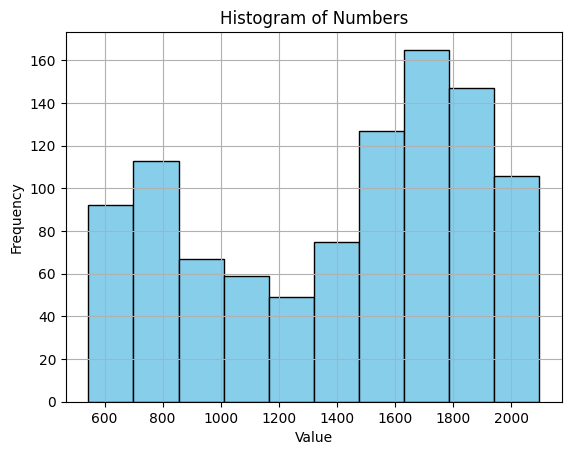

Number of instances of each bucket:
Bucket 1: 92
Bucket 2: 113
Bucket 3: 67
Bucket 4: 59
Bucket 5: 49
Bucket 6: 75
Bucket 7: 127
Bucket 8: 165
Bucket 9: 147
Bucket 10: 106
Min value: 544
Max value: 2097
Variance: 211292.863431


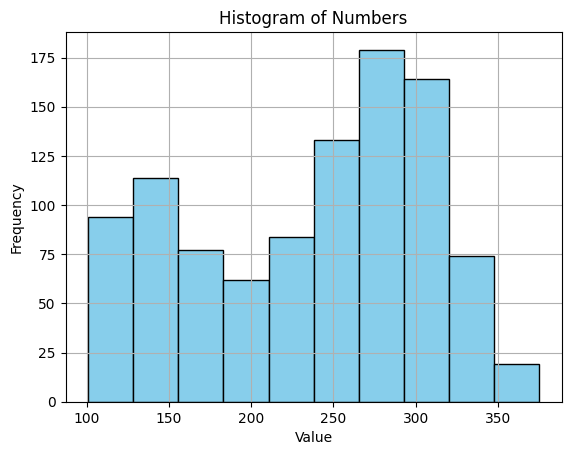

Number of instances of each bucket:
Bucket 1: 94
Bucket 2: 114
Bucket 3: 77
Bucket 4: 62
Bucket 5: 84
Bucket 6: 133
Bucket 7: 179
Bucket 8: 164
Bucket 9: 74
Bucket 10: 19
Min value: 101
Max value: 375
Variance: 5029.783916


In [ ]:
# DATASET EVALUATION
def compute_stats(numbers):
    min_value = min(numbers)
    max_value = max(numbers)
    variance = np.var(numbers)

    plt.hist(numbers, bins=10, color='skyblue', edgecolor='black')
    plt.title('Histogram of Numbers')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    hist, bins = np.histogram(numbers, bins=10)
    print("Number of instances of each bucket:")
    for i in range(len(hist)):
        print(f"Bucket {i+1}: {hist[i]}")

    print(f"Min value: {min_value}")
    print(f"Max value: {max_value}")
    print(f"Variance: {variance}")

compute_stats(list_char)
compute_stats(list_words)

# Data conversion

We implemented this step to have an easier handling of the data. Our model takes numerical inputs, which are the ascii representation of the texts.

In [ ]:
# CONVERSION CHAR TO INT

def convert_char2int_array(matrix,raw_data,row_index):
  col_index = 0
  for c in raw_data[0]:
    # truncation happens for input elements over the desired size
    if(col_index >= desired_size_char):
      break
    matrix[row_index][col_index] = ord(c)
    col_index += 1

def convert_char2int_matrix(dataset):
  # Padding value: zero (as number, not ascii)
  numerical_dataset = np.zeros((len(dataset),desired_size_char))
  index = 0
  for line in dataset:
    # calling a conversion on each row
    convert_char2int_array(numerical_dataset,line, index)
    index+=1
  return numerical_dataset


full_dataset_reviews_num = convert_char2int_matrix(full_dataset_reviews)


In [ ]:
print(full_dataset_reviews_num)

[[ 49.  48.  32. ...   0.   0.   0.]
 [ 84. 104. 105. ...   0.   0.   0.]
 [ 68. 101. 115. ...   0.   0.   0.]
 ...
 [ 83. 101. 114. ...   0.   0.   0.]
 [ 34.  83. 101. ...   0.   0.   0.]
 [ 67.  97. 115. ...   0.   0.   0.]]


# Tensor allocation

We used test_train_split from SKLearn to handle the split, and also the shuffling.

In [ ]:
# TENSORS ALLOCATION
trainX, testX, trainy, testy = train_test_split(full_dataset_reviews_num, full_labels, test_size=0.2, random_state=42)

trainX = np.array(trainX)
testX = np.array(testX)
trainy = np.array(trainy)
testy = np.array(testy)


In [ ]:
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(800, 2000) (800,) (200, 2000) (200,)


In [ ]:
# EARLY STOPPING: based on validation loss and patience
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)

# METRICS: we only have two classes
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

default_learning_rate = 1e-4

NN_callbacks = [es]
NN_batch_size = 20
NN_epochs = 20  # early stop is usually called before reaching this number
NN_split = 0.2  # split ratio between training and validation

# First models
we prepare 4 experimental models, with different architectures. The goal here is to compare which architecture performs better, before considering the network complexity.

# Experiment 1: Low_effort Network
In order to have a baseline for other models performance we implement a simple network made of a Flatten layer and 4 Dense layers. This network has almost no design effort

In [ ]:
##EXPERIMENT 1
def build_model_low_effort(print_summary = False):
  # notes: some dense layers without any real planning. it's a baseline with no design effort.
  model = Sequential()
  model.add(Flatten())

  model.add(Dense(2000, activation='relu'))
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.build(trainX.shape)
  model.compile(loss=loss, optimizer=Adam(learning_rate=default_learning_rate), metrics=metrics)
  if print_summary:
    model.summary()
  return model

build_model_low_effort(True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (800, 2000)               0         
                                                                 
 dense (Dense)               (800, 2000)               4002000   
                                                                 
 dense_1 (Dense)             (800, 1000)               2001000   
                                                                 
 dense_2 (Dense)             (800, 100)                100100    
                                                                 
 dense_3 (Dense)             (800, 1)                  101       
                                                                 
Total params: 6103201 (23.28 MB)
Trainable params: 6103201 (23.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Experiment 2: Cheaper network
The second architecture was implemented by removing the Flatten layer and reducing the number of parameters for the remaining layers by 30% (with a total amount of 4 million parameters).
The goal of this experiment is to see how the performance declines with these changes.


In [ ]:
##EXPERIMENT 2
def build_model_cheaper(print_summary = False):
  #notes: removed Flatten layer, slightly reduced the size of dense layers.
  model = Sequential()

  model.add(Dense(1500, activation='relu'))
  model.add(Dense(700, activation='relu'))
  model.add(Dense(120, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.build(trainX.shape)
  model.compile(loss=loss, optimizer=Adam(learning_rate=default_learning_rate), metrics=metrics)
  if print_summary:
    model.summary()
  return model

build_model_cheaper(True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (1439, 1500)              3001500   
                                                                 
 dense_5 (Dense)             (1439, 700)               1050700   
                                                                 
 dense_6 (Dense)             (1439, 120)               84120     
                                                                 
 dense_7 (Dense)             (1439, 1)                 121       
                                                                 
Total params: 4136441 (15.78 MB)
Trainable params: 4136441 (15.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#  Experiment 3 : Monodimensional Network
For this experiment we try a completely different architecture by introducing Convolutional and Pooling layers.
We know from the laboratory lessons that Conv + Pool pairs are great for pattern recognition and feature extraction and they also have a significantly smaller number of parameters.


In [ ]:
##EXPERIMENT 3
# avoid both Flatten and Embedding. Increased kernel_size to see what happens
def build_model_monodimensional(print_summary = False):
  model = Sequential()

  model.add(Reshape((trainX.shape[1],1)))
  model.add(Conv1D(filters=128, kernel_size=7, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(2))

  model.add(Dense(1, activation='relu'))
  model.add(Flatten())

  model.add(Dense(1, activation='sigmoid'))
  model.build(trainX.shape)
  model.compile(loss=loss, optimizer=Adam(learning_rate=default_learning_rate), metrics=metrics)
  if print_summary:
    model.summary()
  return model

print(trainX.shape)
build_model_monodimensional(True)


(1439, 2000)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (1439, 2000, 1)           0         
                                                                 
 conv1d (Conv1D)             (1439, 1994, 128)         1024      
                                                                 
 max_pooling1d (MaxPooling1  (1439, 664, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (1439, 660, 64)           41024     
                                                                 
 max_pooling1d_1 (MaxPoolin  (1439, 330, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (1439, 328, 

# Experiment 4: Conv1d+Maxpooling1d Network
The Embedding layer is known for its good behavior when we care about feature learning, more specifically this kind of layer maps each word (or character) in our vocabulary to a dense vector of real numbers (the embeddings), which are learned by the model.


In [ ]:
##EXPERIMENT 4
#notes: added Embedding layer, and changed dense layers to conv1d+pooling pairs
def build_model_conv1d(print_summary = False):
  model = Sequential()

  model.add(Embedding(input_dim=NN_batch_size, output_dim=desired_size_char,  input_length=desired_size_char))

  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(2))
  model.add(Flatten())
  model.add(Dropout(0.9))
  model.add(Dense(1, activation='sigmoid'))

  model.build(trainX.shape)
  model.compile(loss=loss, optimizer=Adam(learning_rate=default_learning_rate), metrics=metrics)
  if print_summary:
    model.summary()
  return model

build_model_conv1d(True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 2000)        40000     
                                                                 
 conv1d_3 (Conv1D)           (None, 1998, 32)          192032    
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 999, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 997, 64)           6208      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 498, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 496, 128)         

In [ ]:
# empty arrays to save the results
histories = []
model_names = []
accuracy_results = []
accuracy_val_results = []
loss_results = []
loss_val_results = []
param_size = []

# Training the 4 experiments

Each model is trained separately, and we save the important results from their history.



In [ ]:
# a new model is istantiated every time it's trained
def train_by_index(model_index):
  model = None
  if model_index == 0:
    print("\n Training low effort model \n")
    model = build_model_low_effort()
    model_names.append("Low_effort")
  if model_index == 1:
    print("\n Training cheaper model \n")
    model = build_model_cheaper()
    model_names.append("Cheaper")
  if model_index == 3:
    print("\n Training conv1d model \n")
    model = build_model_conv1d()
    model_names.append("Conv1d")
  if model_index == 2:
    print("\n Training monodimensional model \n")
    model = build_model_monodimensional()
    model_names.append("monodimensional")
  if model == None:
    return

  param_size.append(count_params(model.trainable_weights))

  history = model.fit(trainX, trainy, epochs=NN_epochs, batch_size=NN_batch_size, validation_split=NN_split, callbacks=NN_callbacks)

  del model

  accuracy_results.append(history.history['binary_accuracy'])
  accuracy_val_results.append(history.history['val_binary_accuracy'])
  loss_results.append(history.history['loss'])
  loss_val_results.append(history.history['val_loss'])

In [ ]:
# training all the models on the training_set

train_by_index(0)

train_by_index(1)

train_by_index(2)

train_by_index(3)





 Training low effort model 

Epoch 1/20
58/58 [==============================] - 4s 13ms/step - loss: 9.8772 - binary_accuracy: 0.7394 - val_loss: 3.1322 - val_binary_accuracy: 0.8507
Epoch 2/20
58/58 [==============================] - 0s 7ms/step - loss: 2.5891 - binary_accuracy: 0.7880 - val_loss: 0.9792 - val_binary_accuracy: 0.8125
Epoch 3/20
58/58 [==============================] - 0s 7ms/step - loss: 1.3994 - binary_accuracy: 0.8097 - val_loss: 3.4793 - val_binary_accuracy: 0.7708
Epoch 4/20
58/58 [==============================] - 0s 7ms/step - loss: 0.7608 - binary_accuracy: 0.8584 - val_loss: 2.2916 - val_binary_accuracy: 0.8333
Epoch 5/20
58/58 [==============================] - 0s 7ms/step - loss: 0.7748 - binary_accuracy: 0.8566 - val_loss: 0.9958 - val_binary_accuracy: 0.7917

 Training cheaper model 

Epoch 1/20
58/58 [==============================] - 2s 8ms/step - loss: 6.5828 - binary_accuracy: 0.7464 - val_loss: 2.9143 - val_binary_accuracy: 0.8403
Epoch 2/20
58/58 [

# Comparison of the first 4 experiments

In [ ]:
# PLOTTING the results so far
def plot_learning_curves(names, size):

    # SUBPLOTS: one model per row
    nrows = len(names)
    if nrows == 1:
      nrows +=1
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(14, 18))

    # calculating axis references
    min_acc_array = []
    for res in accuracy_results:
      min_acc_array.append(min(res))
    for res in accuracy_val_results:
      min_acc_array.append(min(res))
    max_los_array = []
    for res in loss_results:
      max_los_array.append(np.mean(res))
    for res in loss_val_results:
      max_los_array.append(np.mean(res))
    min_los_array = []
    for res in loss_results:
      min_los_array.append(min(res))
    for res in loss_val_results:
      min_los_array.append(min(res))

    maxacc = 1
    minacc = min(min_acc_array)
    maxloss = max(max_los_array)
    minloss = min(min_los_array)

    row_index = 0
    minacc = np.floor(minacc*100) * 0.01
    maxw = max(size)
    minw = min(size)/10
    for title in names:

      # FIRST COLUMN: accuracy
      axes[row_index, 0].set_ylim([minacc, maxacc])
      axes[row_index, 0].set_yticks(np.arange(minacc,maxacc,0.05))
      axes[row_index, 0].plot(accuracy_results[row_index], label='Training Accuracy - ' + title)
      axes[row_index, 0].plot(accuracy_val_results[row_index], label='Validation Accuracy - ' + title)
      axes[row_index, 0].set_xlabel('Epoch')
      axes[row_index, 0].set_ylabel('Accuracy')
      axes[row_index, 0].set_title('Training and Validation Accuracy - ' + title)
      axes[row_index, 0].legend()
      # SECOND COLUMN: loss
      axes[row_index, 1].set_yscale('log')
      axes[row_index, 1].set_ylim([minloss, maxloss])
      axes[row_index, 1].plot(loss_results[row_index], label='Training loss - ' + title)
      axes[row_index, 1].plot(loss_val_results[row_index], label='Validation loss - ' + title)
      axes[row_index, 1].set_xlabel('Epoch')
      axes[row_index, 1].set_ylabel('Loss')
      axes[row_index, 1].set_title('Training and Validation loss - ' + title)
      axes[row_index, 1].legend()
      # THIRD COLUMN: network size
      axes[row_index, 2].set_yscale('log')
      axes[row_index, 2].set_ylim([minw, maxw])
      axes[row_index, 2].set_xlim([0, 2])
      axes[row_index, 2].bar(1,size[row_index],linewidth=0.2, tick_label=title)
      axes[row_index, 2].set_title('Size - trainable parameters')

      row_index += 1
    plt.tight_layout()
    plt.show()


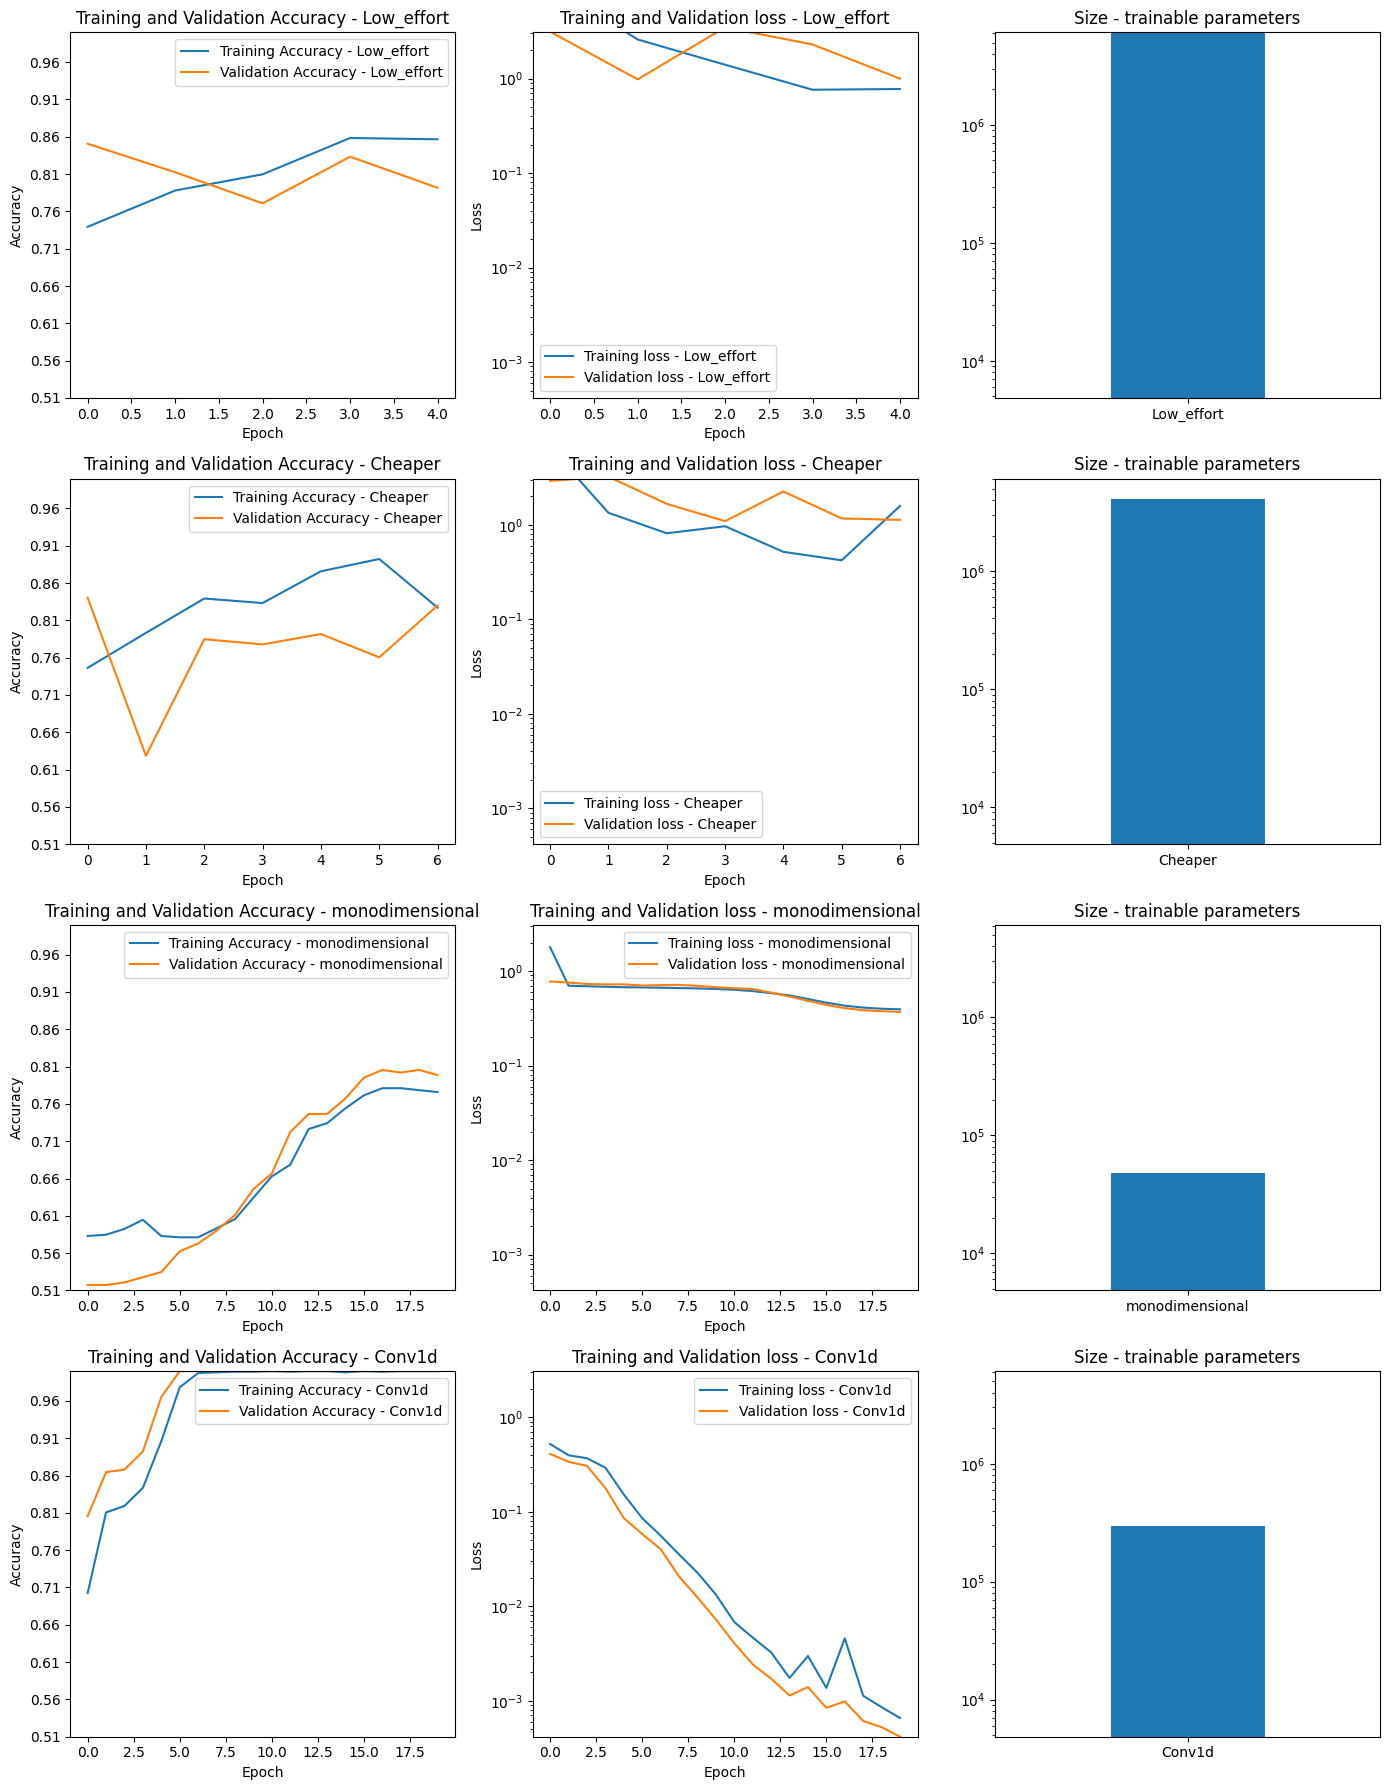

In [ ]:
plot_learning_curves(model_names, param_size)

# Convolutional models

We tested manually how the network behaves by incrementally changing the number of Conv+Pool pairs. We started from 1 pair, and we noticed that it's not useful to put a lot of them.


In [ ]:
# CONVOLUTIONAL MODEL
# notes: now we focus on the model that performed the best, and in particular we want to look at the number of layers
def build_model_xconv(conv_layers,print_summary = False):
  model = Sequential()

  # Embedding layer was a good improvement
  model.add(Embedding(input_dim=NN_batch_size, output_dim=desired_size_char,  input_length=desired_size_char))

  # The number of conv layers is a function parameter
  for i in range(conv_layers+1):
    model.add(Conv1D(filters=80, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))

  model.add(Flatten())
  model.add(Dropout(0.67))
  model.add(Dense(1, activation='sigmoid'))

  model.build(trainX.shape)
  model.compile(loss=loss, optimizer=Adam(learning_rate=default_learning_rate), metrics=metrics)
  if print_summary:
    model.summary()
  return model


In [ ]:
# example of summary
build_model_xconv(5,True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 2000)        40000     
                                                                 
 conv1d (Conv1D)             (None, 1998, 80)          480080    
                                                                 
 max_pooling1d (MaxPooling1  (None, 999, 80)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 997, 80)           19280     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 498, 80)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 496, 80)           1

In [ ]:
# CLEAN HISTORIES
histories = []
model_names = []
accuracy_results = []
accuracy_val_results = []
loss_results = []
loss_val_results = []
param_size = []


In [ ]:
# AGAIN, set fresh models when each training is called
def train_multi_conv(model_index):
  model = build_model_xconv(model_index,False)

  if model == None:
    return

  param_size.append(count_params(model.trainable_weights))
  model_names.append("conv1d "+str(model_index+1)+" layers")
  print("\n Training conv1d model with "+str(model_index+1)+" pooling layers \n")
  history = model.fit(trainX, trainy, epochs=NN_epochs, batch_size=NN_batch_size, validation_split=NN_split, callbacks=NN_callbacks)

  del model

  accuracy_results.append(history.history['binary_accuracy'])
  accuracy_val_results.append(history.history['val_binary_accuracy'])
  loss_results.append(history.history['loss'])
  loss_val_results.append(history.history['val_loss'])

# Training the convolutional networks

We train each model after making it, and we keep saved only the values for the comparison, since none of these are going to be used again later.

In [ ]:
# TRAINING ALL OF THEM
for i in range(5):
  train_multi_conv(i)



 Training conv1d model with 1 pooling layers 

Epoch 1/20
2/2 [==============================] - 8s 2s/step - loss: 0.6898 - binary_accuracy: 0.6316 - val_loss: 0.6532 - val_binary_accuracy: 0.6000
Epoch 2/20
2/2 [==============================] - 0s 199ms/step - loss: 0.6638 - binary_accuracy: 0.6579 - val_loss: 0.6115 - val_binary_accuracy: 0.6000
Epoch 3/20
2/2 [==============================] - 0s 206ms/step - loss: 0.6401 - binary_accuracy: 0.6579 - val_loss: 0.5599 - val_binary_accuracy: 0.6000
Epoch 4/20
2/2 [==============================] - 0s 279ms/step - loss: 0.6175 - binary_accuracy: 0.6053 - val_loss: 0.5064 - val_binary_accuracy: 0.6000
Epoch 5/20
2/2 [==============================] - 0s 104ms/step - loss: 0.5786 - binary_accuracy: 0.6579 - val_loss: 0.4638 - val_binary_accuracy: 0.6000
Epoch 6/20
2/2 [==============================] - 0s 97ms/step - loss: 0.5687 - binary_accuracy: 0.6579 - val_loss: 0.4275 - val_binary_accuracy: 0.6000
Epoch 7/20
2/2 [================

In [ ]:
print(param_size)

[600001, 579201, 578481, 587761, 602001]


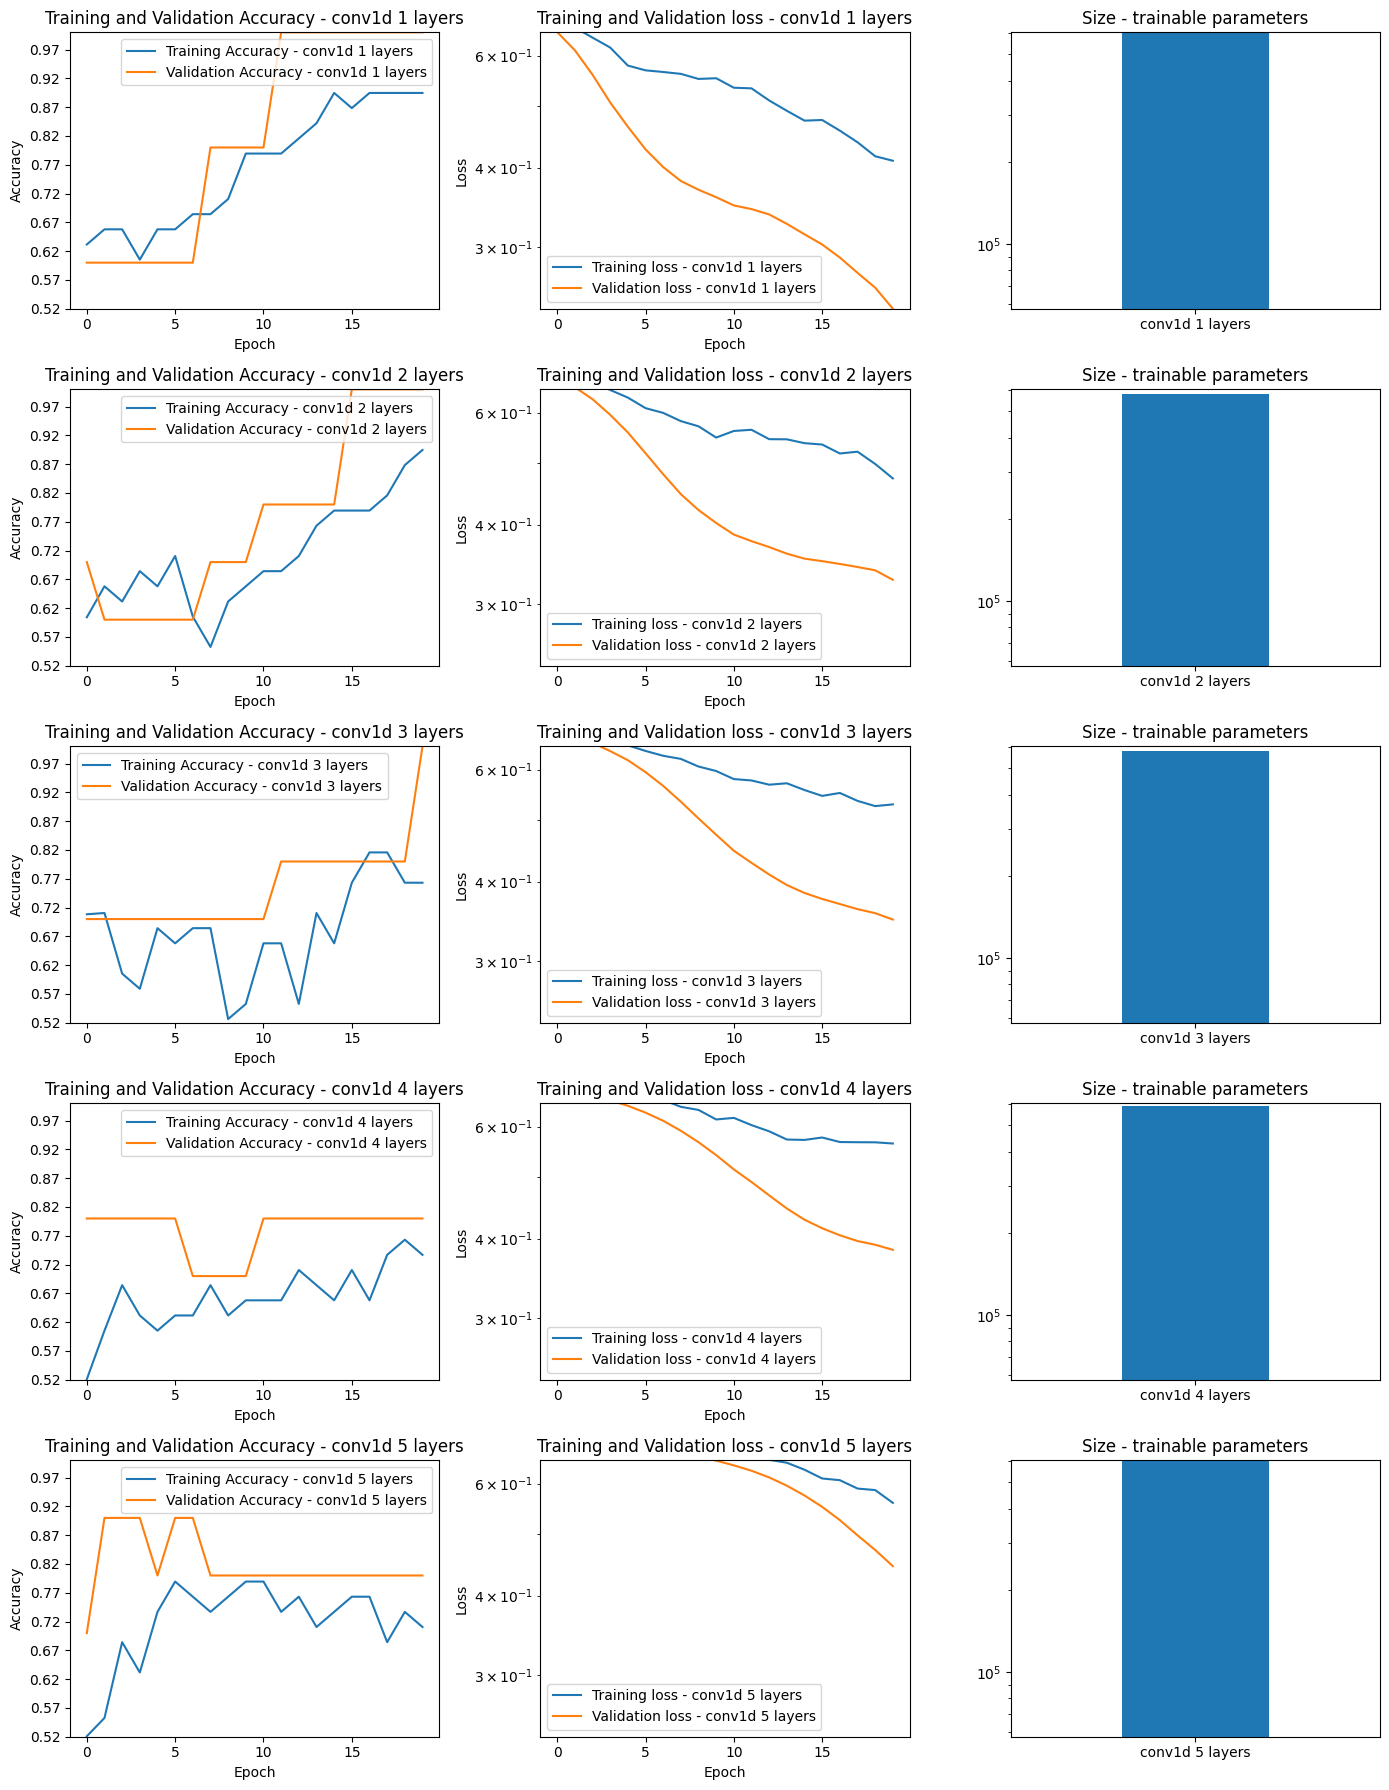

In [ ]:
plot_learning_curves(model_names, param_size)

# Definitive model

We have now found out the best architecture in terms of layers and parameters for our classification problem.


In [ ]:
# TIME TO BUILD AN OPTIMIZED MODEL
def build_definitive_model(embed_dim,l1_size,l2_size,kernel_1,kernel_2,pool_1,pool_2,learning,drop):
  model = Sequential()

  model.add(Embedding(input_dim=NN_batch_size, output_dim=embed_dim,  input_length=desired_size_char))

  # KERNEL SIZE: calculated with Keras Tuner
  model.add(Conv1D(filters=l1_size, kernel_size=kernel_1, activation='relu', padding="valid"))
  # POOLING SIZE: calculated with Keras Tuner
  model.add(MaxPooling1D(pool_1,padding="valid"))
  # KERNEL SIZE: calculated with Keras Tuner
  model.add(Conv1D(filters=l2_size, kernel_size=kernel_2, activation='relu', padding="valid"))
  # POOLING SIZE: calculated with Keras Tuner
  model.add(MaxPooling1D(pool_2,padding="valid"))

  # DROPOUT RATE: calculated with Keras Tuner
  model.add(Flatten())

  model.add(Dropout(drop))

  model.add(Dense(1, activation='sigmoid'))
  model.build(trainX.shape)
  model.compile(loss=loss, optimizer=Adam(learning_rate=learning), metrics=metrics)

  return model



# Tuner search

We pick Hyperband as a tuning algorithm and we turn every parameter into a variable for it.
We started the tuning with our heuristic values and had the tuner search into a wide range around them; then we reduced the range and the look-up step, running the tuner more than once to be sure to have the best combination.


In [ ]:
def build_model_tuner(hp):
  embed_dim = hp.Int('embedded_size', min_value=100, max_value=desired_size_char, step=100)
  hp_units1 = hp.Int('units_l1', min_value=200, max_value=600, step=50)
  hp_units2 = hp.Int('units_l2', min_value=50, max_value=500, step=50)
  hp_k1 = hp.Int('kernel_l1', min_value=2, max_value=10, step=1)
  hp_k2 = hp.Int('kernel_l2', min_value=2, max_value=10, step=1)
  hp_window1 = hp.Int('pooling_size_l1', min_value=2, max_value=5, step=1)
  hp_window2 = hp.Int('pooling_size_l2', min_value=2, max_value=5, step=1)
  drop_10 = hp.Int('dropout_rate', min_value=1, max_value=9, step=1)
  learning = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
  model = build_definitive_model(embed_dim,hp_units1,hp_units2,hp_k1,hp_k2,hp_window1,hp_window2,learning,drop_10/10)
  return model

In [ ]:
# TUNER USING HYPERBAND
# we've seen Hyperband having a good performance in laboratory lessons. We also liked the story behind the the armed bandit problem.
tuner = kt.Hyperband(build_model_tuner,
                     objective='val_binary_accuracy',
                     overwrite=True,
                     max_epochs=NN_epochs,
                     factor=3)

In [ ]:
# TUNER SEARCH:

# CODE IS COMMENTED TO AVOID LONG EXECUTION TIME
tuner.search(trainX, trainy, epochs=NN_epochs, validation_split=NN_split, callbacks=NN_callbacks)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 30 Complete [00h 00m 20s]
val_binary_accuracy: 0.800000011920929

Best val_binary_accuracy So Far: 1.0
Total elapsed time: 00h 06m 48s


In [ ]:
# PRINT TUNING RESULTS
def print_best_hp(hp_set):
  print("Best set of hyperparameters so far:")
  print(f"Embedding size: {hp_set.get('embedded_size')}")
  print(f"Conv1D layer 1 size: {hp_set.get('units_l1')}")
  print(f"Conv1d Kernel 1 size: {hp_set.get('kernel_l1')}")
  print(f"MaxPooling layer 1 size: {hp_set.get('pooling_size_l1')}")
  print(f"Conv1D layer 2 size: {hp_set.get('units_l2')}")
  print(f"Conv1d Kernel 2 size: {hp_set.get('kernel_l2')}")
  print(f"MaxPooling layer 2 size: {hp_set.get('pooling_size_l2')}")
  print(f"dropout: {hp_set.get('dropout_rate')}")
  print(f"learning rate: {hp_set.get('learning_rate')}")


In [ ]:
print_best_hp(best_hps)

Best set of hyperparameters so far:
Embedding size: 800
Conv1D layer 1 size: 200
Conv1d Kernel 1 size: 5
MaxPooling layer 1 size: 3
Conv1D layer 2 size: 300
Conv1d Kernel 2 size: 3
MaxPooling layer 2 size: 4
dropout: 5
learning rate: 0.001


In [ ]:
# FIRST ATTEMPT
embed_dim = 800
hp_units1 = 550
hp_units2 = 500
hp_k1 = 3
hp_k2 = 2
hp_window1 = 4
hp_window2 = 2
drop_10 = 0.2
learning = 1e-4

In [ ]:
# SECOND ATTEMPT
embed_dim = 1000
hp_units1 = 550 # same
hp_units2 = 450
hp_k1 = 5
hp_k2 = 4
hp_window1 = 4 # same
hp_window2 = 3
drop_10 = 0.2 # same
learning = 3e-4


In [ ]:
# FINAL ATTEMPT
embed_dim = 350
hp_units1 = 300 # same
hp_units2 = 150
hp_k1 = 5
hp_k2 = 4
hp_window1 = 4 # same
hp_window2 = 3
drop_10 = 0.2 # same
learning = 3e-4


In [ ]:
hp_names = ['embedded_size','units_l1','units_l2','kernel_l1','kernel_l2','pooling_size_l1','pooling_size_l2','dropout_rate','learning_rate']
hyperparameters = [embed_dim,hp_units1,hp_units2,hp_k1,hp_k2,hp_window1,hp_window2,drop_10,learning]


# Alternate tuner search

Just for curiosity, we implemeneted a different tuner that optimize just one parameter at each iteration. The results are more or less the same.

In [ ]:
# REFINED TUNER SEARCH

hp_search_index = 0
t_model = None

def refined_tuner(hp):
  global t_model
  global hp_search_index
  del t_model
  print("Parameter search: "+hp_names[hp_search_index])
  if hp_search_index == 0:
    hyperparameters[hp_search_index] = hp.Int('embedded_size', min_value=600, max_value=1000, step=50)
  if hp_search_index == 1:
    hyperparameters[hp_search_index] = hp.Int('units_l1', min_value=400, max_value=700, step=50)
  if hp_search_index == 2:
    hyperparameters[hp_search_index] = hp.Int('units_l2', min_value=250, max_value=600, step=50)
  if hp_search_index == 3:
    hyperparameters[hp_search_index] = hp.Int('kernel_l1', min_value=2, max_value=5, step=1)
  if hp_search_index == 4:
    hyperparameters[hp_search_index] = hp.Int('kernel_l2', min_value=2, max_value=4, step=1)
  if hp_search_index == 5:
    hyperparameters[hp_search_index] = hp.Int('pooling_size_l1', min_value=2, max_value=6, step=1)
  if hp_search_index == 6:
    hyperparameters[hp_search_index] = hp.Int('pooling_size_l2', min_value=2, max_value=5, step=1)
  if hp_search_index == 7:
    hyperparameters[hp_search_index] = hp.Choice('dropout_rate', values = [0.15, 0.2, 0.25])
  if hp_search_index == 8:
    hyperparameters[hp_search_index] = hp.Choice('learning_rate', values = [1e-4, 3e-4, 6e-4])

  t_model = build_definitive_model(hyperparameters[0],hyperparameters[1],hyperparameters[2],hyperparameters[3],hyperparameters[4],hyperparameters[5],hyperparameters[6],hyperparameters[7],hyperparameters[8])
  return t_model

def finetune_hp(hp_index):
  global hp_search_index
  hp_search_index = hp_index%len(hyperparameters)
  hpfinetuner = kt.Hyperband(refined_tuner,
                     objective='val_binary_accuracy',
                     overwrite=True,
                     max_epochs=NN_epochs,
                     factor=3)

  hpfinetuner.search(trainX, trainy, epochs=NN_epochs, validation_split=NN_split, callbacks=NN_callbacks)

  # Get the optimal hyperparameters
  finetuned_hps = hpfinetuner.get_best_hyperparameters(num_trials=1)[0]
  del hpfinetuner

  hyperparameters[hp_search_index] = finetuned_hps.get(hp_names[hp_search_index])
  print("Checkpoint reached: "+hp_names[hp_search_index])
  print(hyperparameters)

for i in range(len(hyperparameters)):
  finetune_hp(i)



Trial 3 Complete [00h 00m 04s]
val_binary_accuracy: 1.0

Best val_binary_accuracy So Far: 1.0
Total elapsed time: 00h 00m 11s
Checkpoint reached: learning_rate
[700, 400, 550, 3, 2, 6, 5, 0.2, 0.0001]


In [ ]:
best_hp_zip = dict(zip(hp_names, hyperparameters))

print_best_hp(best_hp_zip)

Best set of hyperparameters so far:
Embedding size: 350
Conv1D layer 1 size: 300
Conv1d Kernel 1 size: 5
MaxPooling layer 1 size: 4
Conv1D layer 2 size: 150
Conv1d Kernel 2 size: 4
MaxPooling layer 2 size: 3
dropout: 0.2
learning rate: 0.0003


# Final model

This is the definitive model that we are going to test, and we use the results of the tuner to build it.

In [ ]:
# TESTING: time to assemble the best model with tuned hyperparameters
# [embed_dim,hp_units1,hp_units2,hp_k1,hp_k2,hp_window1,hp_window2,drop_10,learning]
final_model = build_definitive_model(hyperparameters[0],hyperparameters[1],hyperparameters[2],hyperparameters[3],hyperparameters[4],hyperparameters[5],hyperparameters[6],hyperparameters[7],hyperparameters[8])


In [ ]:
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 350)         7000      
                                                                 
 conv1d (Conv1D)             (None, 1996, 300)         525300    
                                                                 
 max_pooling1d (MaxPooling1  (None, 499, 300)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 150)          180150    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 165, 150)          0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 24750)            

# Training phase

The refined model is trained with the small dataset

In [ ]:
# TRAINING
# number of epochs is bigger, to make sure the training stops only after the patience criteria
final_history = final_model.fit(trainX, trainy, epochs=3*NN_epochs, batch_size=NN_batch_size, validation_split=NN_split, callbacks=NN_callbacks)

Epoch 1/60
32/32 [==============================] - 13s 178ms/step - loss: 52376.7891 - binary_accuracy: 0.7719 - val_loss: 22465.3906 - val_binary_accuracy: 0.9688
Epoch 2/60
32/32 [==============================] - 2s 75ms/step - loss: 2665.9299 - binary_accuracy: 0.9953 - val_loss: 0.0194 - val_binary_accuracy: 1.0000
Epoch 3/60
32/32 [==============================] - 2s 63ms/step - loss: 0.7040 - binary_accuracy: 0.9953 - val_loss: 0.0120 - val_binary_accuracy: 1.0000
Epoch 4/60
32/32 [==============================] - 2s 63ms/step - loss: 0.0157 - binary_accuracy: 0.9984 - val_loss: 0.0091 - val_binary_accuracy: 1.0000
Epoch 5/60
32/32 [==============================] - 2s 79ms/step - loss: 0.0137 - binary_accuracy: 0.9984 - val_loss: 0.0069 - val_binary_accuracy: 1.0000
Epoch 6/60
32/32 [==============================] - 2s 67ms/step - loss: 0.0126 - binary_accuracy: 0.9984 - val_loss: 0.0056 - val_binary_accuracy: 1.0000
Epoch 7/60
32/32 [==============================] - 2s 58

# Validation results

The plots here are used for the comparison with the performance of the other models.

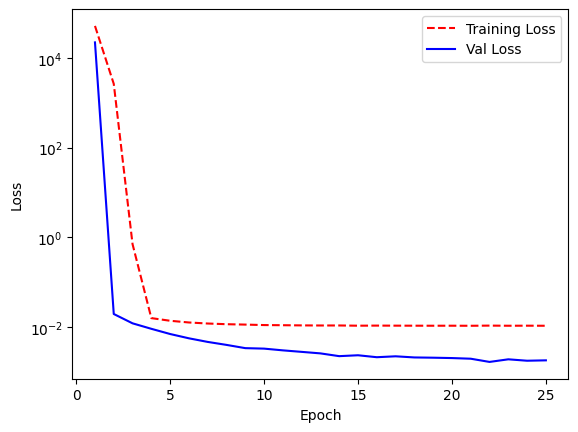

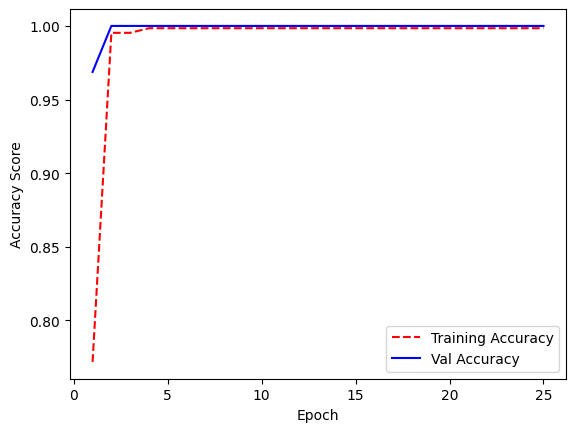

In [ ]:
# MAKING A CLEAN GRAPH FOR TRAINING AND VALIDATION
training_loss = final_history.history["loss"]
val_loss = final_history.history["val_loss"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.yscale("log")
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, val_loss, "b-")
plt.legend(["Training Loss", "Val Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

epoch_count = range(1, len(training_loss) + 1)
training_accuracy = final_history.history["binary_accuracy"]
val_accuracy = final_history.history["val_binary_accuracy"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, val_accuracy, "b-")

# Visualize accuracy history
plt.legend(["Training Accuracy", "Val Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show();

# Testing phase

In [ ]:
# TEST PHASE, USING THE TEST SET
scores = list()

# evaluate model
_, test_accuracy = final_model.evaluate(testX, testy, batch_size=NN_batch_size, verbose=0)
test_accuracy = test_accuracy * 100.0
print('>#%d: %.3f' % (1, test_accuracy))
scores.append(test_accuracy)

# summarize results
m, s = np.mean(scores), np.std(scores)
print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

>#1: 100.000
Accuracy: 100.000% (+/-0.000)


In [ ]:
# CONFUSION MATRIX TO PLOT THE CLASSIFICATION RESULTS
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Bot Review Detected (True Negatives): ', cm[0][0])
  print('Bot Review Incorrectly Detected (False Positives): ', cm[0][1])
  print('Human Review Missed (False Negatives): ', cm[1][0])
  print('Human Review Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Traffic: ', np.sum(cm[1]))

10/10 [==============================] - 0s 20ms/step
Bot Review Detected (True Negatives):  104
Bot Review Incorrectly Detected (False Positives):  0
Human Review Missed (False Negatives):  0
Human Review Detected (True Positives):  96
Total Fraudulent Traffic:  96


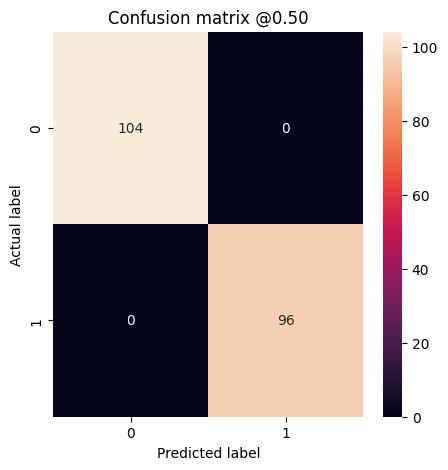

In [ ]:
test_predictions_baseline = final_model.predict(testX, batch_size=NN_batch_size)
plot_cm(testy, test_predictions_baseline)